In [1]:
from typing import List
import torch
from PIL import Image
from diffusers import StableDiffusionPipeline
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from utils.magnet_utils import *
from utils.vis_utils import *
from utils.ptp_utils import *
from pytorch_lightning import seed_everything
from torch.nn import functional as F

/home/hy/anaconda3/envs/magnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable_diffusion_version = "path-to-stable-diffusion-v1-4"
stable = StableDiffusionPipeline.from_pretrained(stable_diffusion_version).to(device)

tokenizer = stable.tokenizer
text_encoder = stable.text_encoder.eval()
NUM_DDIM_STEPS = 50

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/home/hy/anaconda3/envs/magnet/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


In [3]:
@torch.no_grad()
def get_prompt_embeds(_prompt):
    check_prompt_ids = tokenizer(_prompt, padding=False, truncation=True, return_tensors="pt").input_ids.to(device)
    _eot_index = check_prompt_ids.shape[1] - 1

    _prompt_ids = tokenizer(_prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt").input_ids.to(device)
    _prompt_embs = text_encoder(_prompt_ids)[0]
    return _prompt_embs, _eot_index

def get_eot(_prompt, eot_no=0):    
    # eot_no = -1: first word before eot
    # eot_no = 0: first eot
    _prompt_embs, _eot_id = get_prompt_embeds(_prompt)
    _target = _prompt_embs[:, _eot_id+eot_no]
    return _target

def get_non_eot(_prompt):
    # eot_no = -1: first word before eot
    # eot_no = 0: first eot
    _prompt_embs, _eot_id = get_prompt_embeds(_prompt)
    _target = _prompt_embs[:, :_eot_id]
    return _target

def distance(point1, point2):
    return (point1 - point2).norm(dim=-1)


def attribution_bias(_obj, _attrs, _eot_no=0):
    center_embs = get_eot(_obj, eot_no=_eot_no)
    
    all_sim = []
    all_scale = []
    all_vec = []
    for _attr in _attrs:
        attr_embs = get_eot(f"{_attr} {_obj}", eot_no=_eot_no)

        # sim = center_embs @ attr_embs.T
        # all_sim.append(sim.squeeze(0))
        sim = F.cosine_similarity(center_embs, attr_embs)
        all_sim.append(sim)

        vec = attr_embs - center_embs
        all_vec.append(vec)

        scale = vec.norm(dim=-1)
        all_scale.append(scale)

    all_vec = torch.cat(all_vec, dim=0)
    all_sim = torch.cat(all_sim, dim=0)
    all_scale = torch.cat(all_scale, dim=0)
    
    return all_sim, all_scale


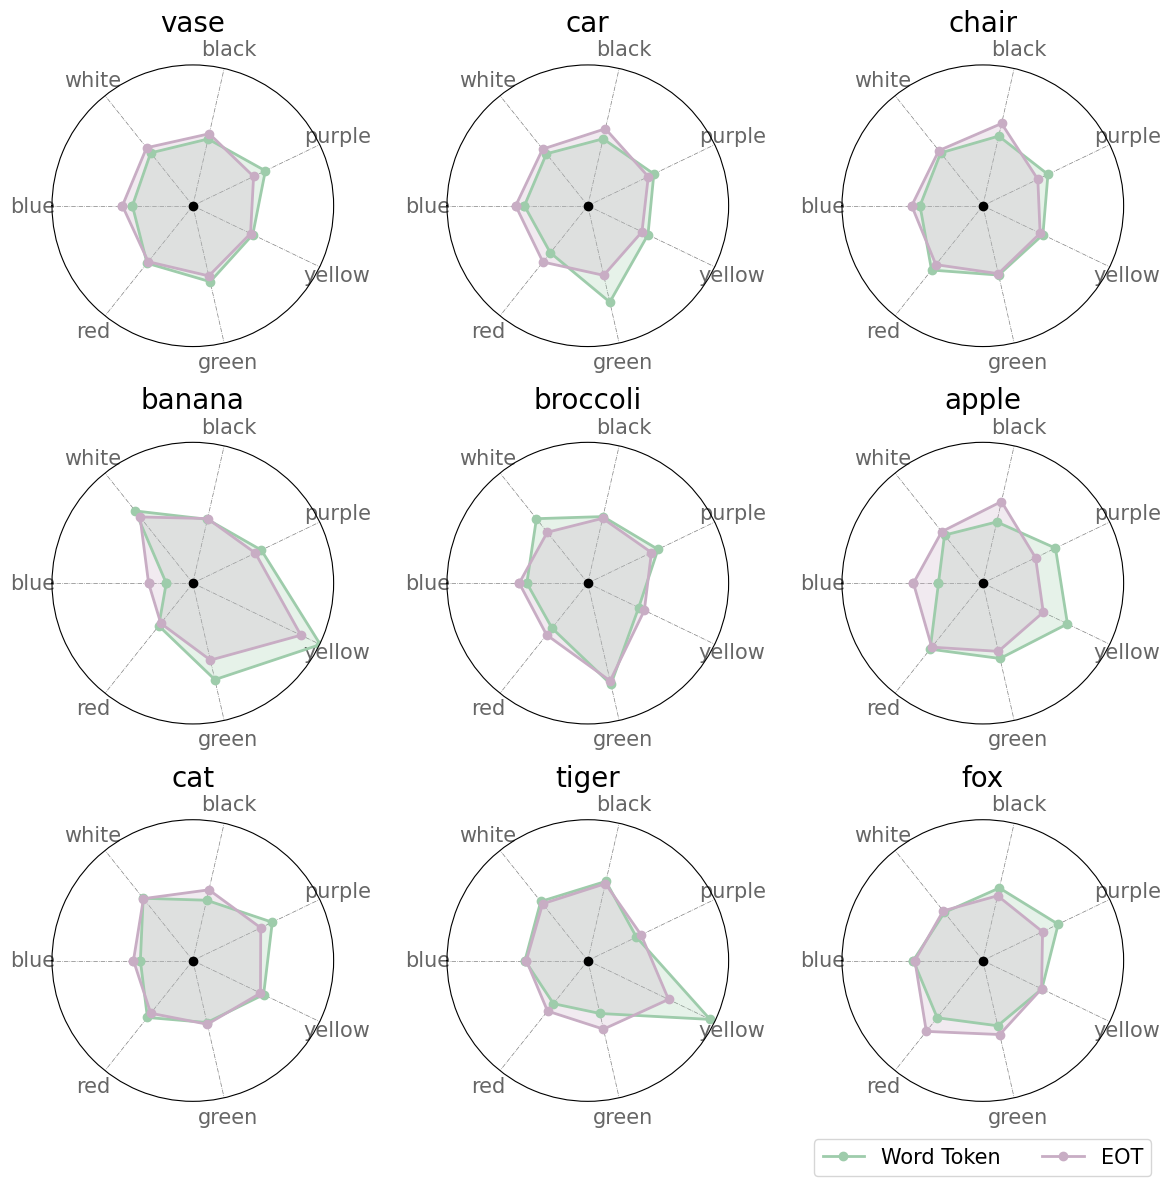

In [16]:
import matplotlib.pyplot as plt

colors = ["blue", "red", "green", "yellow", "purple", "black", "white"]
objs = ["vase", "car", "chair", "banana", "broccoli", "apple", "cat", "tiger", "fox"]

TOKEN = 0

fontsize = 15

fig = plt.figure(figsize=(12, 12), layout="constrained")
fig.get_layout_engine().set(wspace=.1, w_pad=.5)
axs = fig.subplots(3, 3, subplot_kw=dict(projection='polar'), sharex=True, sharey=True)

axs = [axs[0,0], axs[0,1], axs[0,2], axs[1,0], axs[1,1],axs[1,2], axs[2,0], axs[2,1], axs[2,2]]

draw_colors = ["#9eccab", "#c8adc4"]
show_labels = ["Word Token", "EOT"]
N = len(colors)

for ax, obj_word in zip(axs, objs):

    obj_sim, obj_scale = attribution_bias(obj_word, colors, TOKEN-1)
    eot_sim, eot_scale = attribution_bias(obj_word, colors, TOKEN)
    obj_bias = torch.div(obj_sim / obj_sim.sum(), obj_scale / obj_scale.sum())
    eot_bias = torch.div(eot_sim / eot_sim.sum(), eot_scale / eot_scale.sum())

    labels = np.concatenate((np.array(colors), [np.array(colors)[0]]))

    stats = obj_bias.cpu().numpy()
    angles = np.linspace(0, 2*np.pi, N, endpoint=False)
    stats = np.concatenate((stats, [stats[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    ax.plot(angles, stats, 'o-', linewidth=2, c=draw_colors[0], label=show_labels[0])
    ax.fill(angles, stats, alpha=0.25, c=draw_colors[0]) 
    ax.set_thetagrids(angles[:-1]*180/np.pi,
                    labels[:-1],
                    fontsize=fontsize, alpha=0.6)


    stats2 = eot_bias.cpu().numpy()
    angles2 = np.linspace(0, 2*np.pi, N, endpoint=False)
    stats2 = np.concatenate((stats2, [stats2[0]]))
    angles2 = np.concatenate((angles2, [angles2[0]]))

    ax.plot(angles2, stats2, 'o-', linewidth=2, c=draw_colors[1], label=show_labels[1])
    ax.fill(angles2, stats2, alpha=0.25, c=draw_colors[1])

    ax.set_ylim(ymin=0, ymax=2)
    ax.set_theta_zero_location('W')
    ax.grid(False)
    ax.set_yticks([])

    for j in range(N):
        ax.plot([angles[j], angles[j]], [0, 100], '-.', lw=0.5, color='gray', zorder=0)

    ax.scatter(x=0, y=0, c='black', alpha=1, zorder=10)
    ax.set_title(f"{obj_word}", fontsize=fontsize+5)

plt.tight_layout()
plt.yticks([], alpha=0)
plt.legend(loc="center", bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=fontsize)
plt.tight_layout()

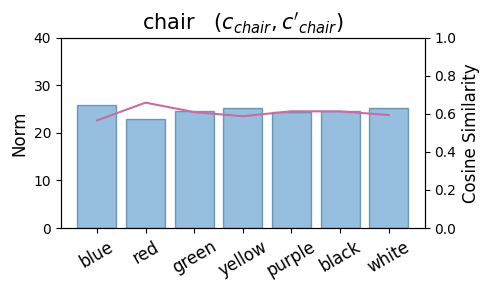

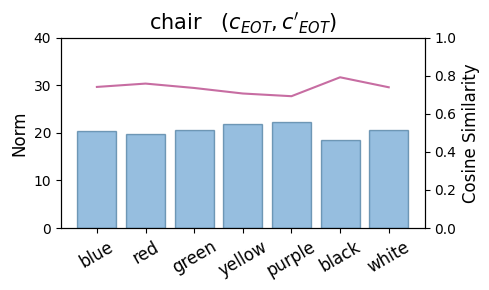

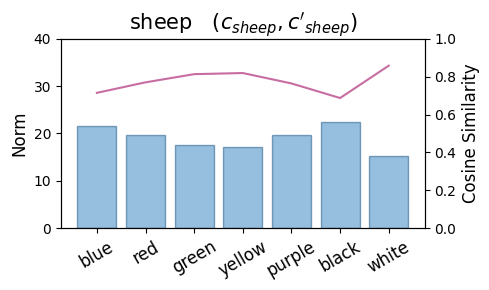

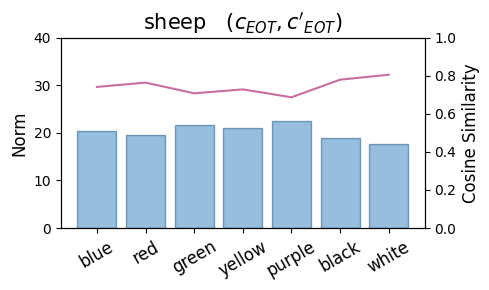

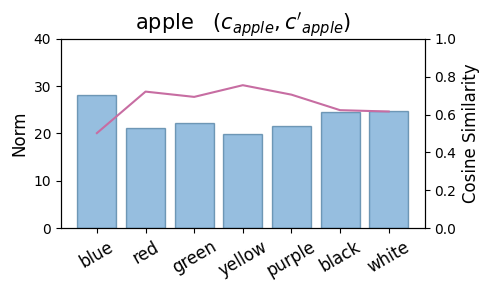

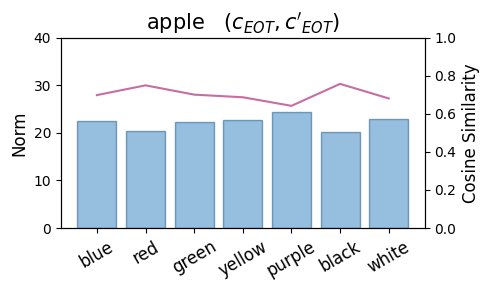

: 

In [20]:
for obj_title in ["chair", "sheep", "apple"]:

    obj_sim, obj_scale = attribution_bias(obj_title, colors, TOKEN-1)
    eot_sim, eot_scale = attribution_bias(obj_title, colors, TOKEN)

    fig, ax1 = plt.subplots(ncols=1, figsize=(5, 3))

    x_values = np.arange(len(colors))
    y_values = obj_scale.cpu().numpy()

    y2_values = obj_sim.cpu().numpy()

    ax1.bar(x_values, y_values, color="#2f7fc1", edgecolor="#14517c", alpha=0.5)
    plt.ylabel('Norm', fontsize=12)
    
    ax2 = ax1.twinx()
    ax2.plot(x_values, y2_values, alpha=1, c='#c76da2')

    labels = np.array(colors)
    ax1.set_xticks(np.arange(len(colors)))
    ax1.set_yticks(np.arange(0, 41, 10))
    ax1.set_xticklabels(labels, rotation=30, fontsize=12)
    plt.ylabel('Cosine Similarity', fontsize=12)

    if obj_title == "chair":
        plt.title(f"{obj_title}\t"+r"$(c_{chair}, c'_{chair})$", fontsize=15)
    elif obj_title == "sheep":
        plt.title(f"{obj_title}\t"+r"$(c_{sheep}, c'_{sheep})$", fontsize=15)
    elif obj_title == "apple":
        plt.title(f"{obj_title}\t"+r"$(c_{apple}, c'_{apple})$", fontsize=15)
    plt.ylim([0., 1])
    plt.tight_layout()

    eot_sim, eot_scale = attribution_bias(obj_title, colors, TOKEN)

    fig, ax1 = plt.subplots(ncols=1, figsize=(5, 3))

    x_values = np.arange(len(colors))
    y_values = eot_scale.cpu().numpy()

    y2_values = eot_sim.cpu().numpy()

    lns1 = ax1.bar(x_values, y_values, color="#2f7fc1", edgecolor="#14517c", alpha=0.5, label="distance")
    plt.ylabel('Norm', fontsize=12)
    
    ax2 = ax1.twinx()
    lns2 = ax2.plot(x_values, y2_values, alpha=1, c='#c76da2', label="similarity")

    labels = np.array(colors)
    ax1.set_xticks(np.arange(len(colors)))
    ax1.set_yticks(np.arange(0, 41, 10))
    ax1.set_xticklabels(labels, rotation=30, fontsize=12)
    plt.ylabel('Cosine Similarity', fontsize=12)

    plt.title(f"{obj_title}\t"+r"$(c_{EOT}, c'_{EOT})$", fontsize=15)
    plt.ylim([0., 1])
    plt.tight_layout()
